In [1]:
#random mutagenesis engineering 

#given one sequence to work with- run random mutagenesis for X iterations to get a high score and a low score.
#try and engineer the highest score you can 

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random 
from sklearn.linear_model import LinearRegression
import keras
from keras.models import load_model 
from sklearn import preprocessing
import pickle
from pickle import dump, load

import io
import sys

%matplotlib inline

In [2]:
# this imports the model which considers position, with k=3.
model = pickle.load(open("best_linreg_model.pkl", "rb"))
k = 3

In [3]:
#3.1 functions

################### Provided functions, you will not need to edit these ##################################3
def plotPredictionChanges(predictionValues, graphTitle):
    #plot the change in predicted values 
    plt.plot(list(range(0, len(predictionValues))), predictionValues)
    plt.xlabel("Iteration")
    plt.ylabel("Predicted MRL")
    plt.title(graphTitle)
    plt.show()
    

In [4]:
################ You will need to edit these functions for 3.1 ############################

#  Behavior  : changes exactly one nucleotide at a random index in the given
#              sequence to a different nucleotide
#  Parameters: 'sequence' - a String that represents DNA ("ACGT"s)
#  Returns   : the mutated sequence
def mutate(sequence):
    # get a random index
    index = random.randint(0, len(sequence) - 1)
    
    # only consider basepairs different than the one at the index
    useful_bps = "ACGT".replace(sequence[index], "")
    
    # choose a basepair to mutate to
    new_bp = random.choice(useful_bps)
    
    # change the sequence
    sequence = sequence[0:index] + new_bp + sequence[index + 1 : len(sequence)]
    
    return sequence

#  Behavior  : runs a prediction for a sequence using your pretrained sklearnModel
#              (Don't forget to add 1 column on for bias term in linear regression )
#              x = np.hstack((np.ones((len(x),1)), x))
#  Parameters: 'sequence' - a String that represents DNA
#              'sklearnModel' - a SciKit learning model
#              'k' - number of nucleotides to look at at one time
#              'kmer_dict' - dictionary with kmer Strings as keys, and integer indices as values.
#  Returns   : the predicted MRL for the given sequence (float)
def runLinearRegressionPrediction(sequence, sklearnModel, k, kmer_dict):
    #TODO:
    #runs a prediction for a sequence using your pretrained sklearnModel
    #(Don't forget to add 1 column on for bias term in linear regression )
    #x = np.hstack((np.ones((len(x),1)), x))

    # 'sequence' is put in brackets because this method expects a list.
    mat = count_kmers_with_positions([sequence], kmer_dict, k)
    return sklearnModel.predict(mat)

#  Behavior  : starting with the starting sequence, makes 1-nt mutations and checks if the
#              predicted MRL of that is better than the original sequence. Repeats this 
#              process 'number_iterations' times.
#  Parameters: 'starting_sequence' - initial sequence to start mutating
#              'sklearnModel' - trained model
#              'kmer_dict' - dictionary with kmer Strings as keys, and integer indices as values.
#              'number_iterations' - how many times to mutate the sequence
#              'k' - number of BPs for the model
#  Returns   : the final String sequence with best MRL, and a list of all intermediate
#              predicted values.
def mutagenesis_higher_mrl(starting_sequence, sklearnModel, kmer_dict, number_iterations, k):
    
    predictions = []
    #make initial prediction
    starting_prediction = runLinearRegressionPrediction(starting_sequence, sklearnModel, k, kmer_dict)
    predictions.append(starting_prediction)
    for i in range(0, number_iterations):
        #TODO:
        #1) make mutation to starting sequence
        #2) check if the mutant prediction is higher than past prediction & keep the higher 
        #3) append the prediction value to predictions
        mutated_sequence = mutate(starting_sequence)
        mutated_prediction = runLinearRegressionPrediction(mutated_sequence, sklearnModel, k, kmer_dict)
        if mutated_prediction > starting_prediction : 
            starting_sequence = mutated_sequence
            starting_prediction = mutated_prediction
        predictions.append(starting_prediction)
        
    return starting_sequence, predictions
    
#  Behavior  : creates a 50 nt long random sequence of DNA
#  Parameters: none.
#  Returns   : a String of length 50 which represents DNA ("ACGT")
def get50RandomNTs():
    #TODO: return a 50 nt random sequence 
    #Hint: take a look at random.choice
    seq =""
    for i in range (50):
        seq += random.choice("ATCG")
    return seq

In [5]:
#3.1
#TODO: copy your linear regression functions here
#TODO: train your best linear regression model from 2 to use for sequene design
    ### this step is completed by importing it


def create_kmer_dict(k):
    # Create dictionary where the keys are kmer strings, and the value for each key is an integer index,
    #  i.e. kmer_dict.values should return an np.array equal to range(4**k) This function will be used to
    #  create consistent indexing for kmers across the other functions in this cell & notebook.
    bases = ['A', 'C', 'G', 'T']

    kmer_dict = {}
    for i, kmer in zip(range(4**k), itertools.product('ACGT', repeat=k)):
        string = ''.join(kmer)
        kmer_dict[string] = i

    return kmer_dict

#  Behavior  : for all sequences in list 's', counts the number of kmers with position information.
#  Parameters: 's' - a list of sequences
#              'kmer_dict' -
#              'k' - 
#  Returns   : a 2D numpy array with said info. the order of counts has the different frames
#              organized together (i.e. frame 0 is from 0 to 4^k - 1, frame 1 is from 4^k to 2 * 4^k - 1).
#              Within each one of these chapters, organization is AA -> AC -> AG -> AT -> CA -> etc.
def count_kmers_with_positions(s, kmer_dict, k):
    #for every sequence in list s, count the number of kmers with position information (see example in instructions)
    stride = 3
    counts = np.zeros((len(s), 4**k * stride))
    #TODO: fill in counts matrix
    
    # for each sequence, look at each kmer, determine which frame it is in, and
    # then increment the count of the appropriate index
    for numSeq, seq in zip(range(len(s)), s):
        for pos in range(len(seq) - k + 1):
            kmer = seq[pos:pos+k]
            frame = (pos - len(seq)) % stride
            index = frame * 4**k + kmer_dict[kmer]
            counts[numSeq][index] += 1
    
    return counts

In [6]:
kmer_dict = create_kmer_dict(k)

Start sequence: 
GACTTCGGCGTCCTGAGTACCTAATTATTTCCACCCCCAGGCAAACCCAC
[7.515625]
End sequence: 
GGCTTCCGACTGCTGAGATCCTAATTATCTACACTTCCAGCAAATCTCAA
[8.453125]


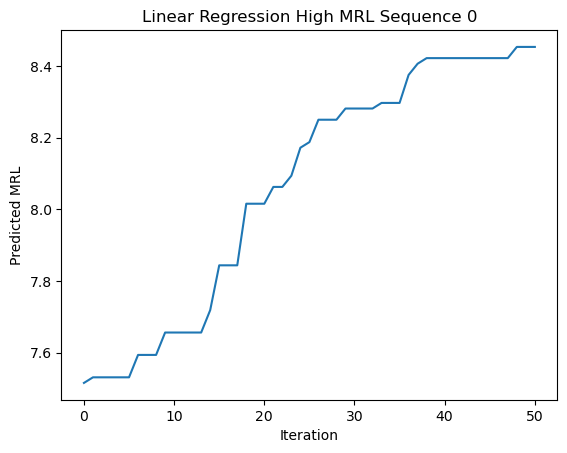

Start sequence: 
CTCGGAAAAGGCGCAAAGAATTTACACCTTCACCACCCAAATTTCCCTTT
[7.09375]
End sequence: 
CTCCAAAGATTTGTAAATATTTAACACCTAGAATTGCCAACTCTTCCTTG
[8.9375]


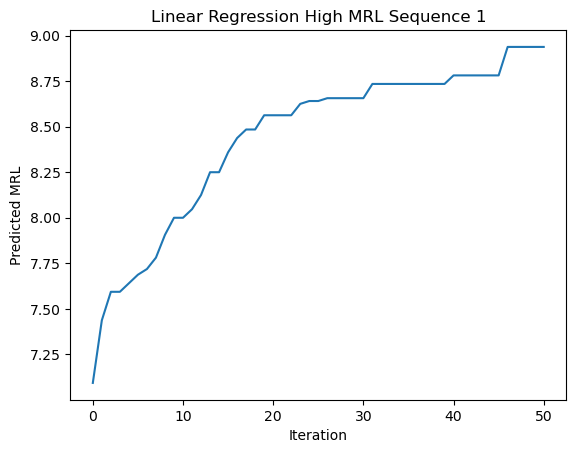

Start sequence: 
GTAGTAGTAGAAAGTGCTGTTTTCTGTCAACGAAAAGCTCTAACGGCGGA
[7.90625]
End sequence: 
ATAATAGTAGAAATTGCTGTGTTCTGACCAAGAACAGATCTGAGTGCGTA
[9.03125]


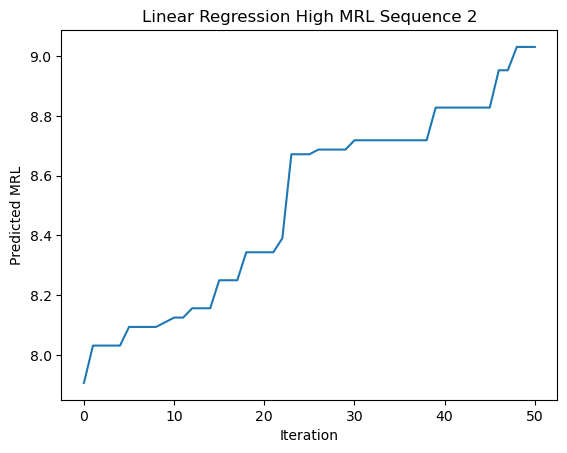

In [7]:
#3.1 
################### Don't need to edit these, just run this cell ####################################
# one edit made: changed input k value from 5 to 3 as this was the optimal k for model.
for i in range(0, 3):
    #attempt higher mutation 
    x = get50RandomNTs()
    print ("Start sequence: ")
    print (x)
    end_seq, values = mutagenesis_higher_mrl(x, model, kmer_dict, 50, 3)
    print (values[0])
    print ('End sequence: ')
    print(end_seq)
    print  (values[-1])
    plotPredictionChanges(values, "Linear Regression High MRL Sequence " + str(i))
    

In [8]:
#3.2
#Now, attempt the same using optimus 5-prime staring with a randomnly generated 50 nt sequence 
#1) download the retrained_main_MRL_model from github (https://github.com/pjsample/human_5utr_modeling/tree/master/modeling/saved_models)


################### Provided functions, you will not need to edit these ##################################3

def one_hot_encode(seq, seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    # Creat empty matrix.
    vectors=np.empty([1,seq_len,4])
    seq = seq.lower()
    a = np.array([nuc_d[x] for x in seq])
    vectors[0] = a
    return vectors

def make_optimus_prediction(seq, model, scaler):
    #one hot encode sequence 
    oneHot = one_hot_encode(seq)
    # Make predictions
    predictions = model.predict(oneHot).reshape(1, -1)
    # scale predictions to true MRL 
    return scaler.inverse_transform(predictions)[0]

def load_scaler():
    return load(open('optimus_scaler.pkl', 'rb'))


In [9]:
################ You will need to edit these functions for 3.2 ############################

def mutagenesis_higher_mrl_optimus(starting_sequence, model, scaler, number_iterations):
    #TODO: modify your function from before to use one_hot_encode, make_optimus_prediction 
    #output: return your end sequence, a list of the predicted value for each iteration
    
    
    # the next three lines (and the last line in this method) serve to make the text
    # output that occurs from calling the make_optimus_prediction method. Though not
    # strictly, necessary, it does make the output nicer. 
    
    text_trap = io.StringIO()
    og_stdout = sys.stdout
    sys.stdout = text_trap

    
    predictions = []
    
    best_seq = starting_sequence
    best_pred = make_optimus_prediction(best_seq, model, scaler)
    predictions.append(best_pred)
    for i in range(number_iterations):
        mut_seq = mutate(best_seq)
        mut_pred = make_optimus_prediction(mut_seq, model, scaler)
        if (mut_pred > best_pred):
            best_pred = mut_pred
            best_seq = mut_seq
        predictions.append(best_pred)
        
    sys.stdout = og_stdout
    
    return best_seq, predictions

In [10]:
#3.2
#load downloaded keras model 
################### Don't need to edit these, just run this cell ####################################
kerasModelName = "retrained_main_MRL_model.hdf5"
model = load_model(kerasModelName)

2022-12-14 15:58:51.929619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#get scaler for the optimus model 
################### Don't need to edit these, just run this cell ####################################
scaler = load_scaler()

/Users/joshwentzien/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Start sequence: 
TCCGTACCCTAGGTGTCTACAGGTCGCACAGTGCACGCTACGTGAGCCCT
[7.098548]
End sequence: 
CCCGAATCCTAGATATTTTCAGGTCTCAGAGTACACTATACGTGAGCACT
[8.013684]


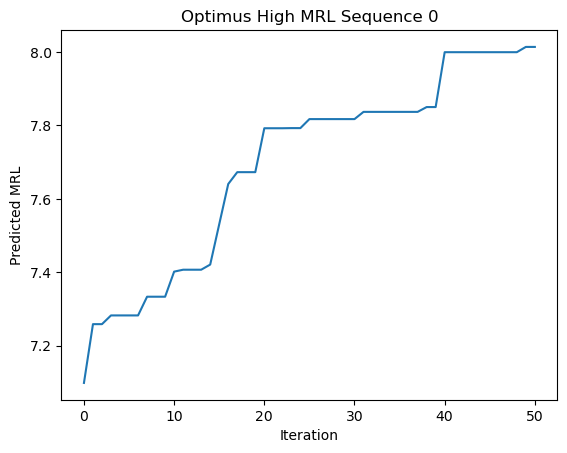

Start sequence: 
CCTACAGCACCTGAACTTCATAATACTGAAGTTCACCGGCGCTACTGAAG
[7.305227]
End sequence: 
CCCACAAAACCGGAACTTCATATTTCAGAGCTTCACCTGAGCTAATGATT
[8.020946]


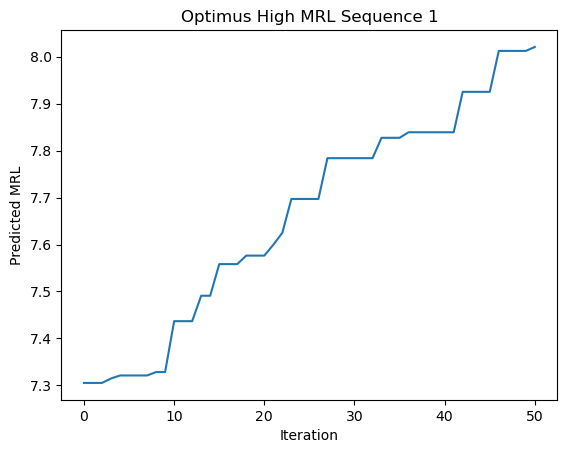

Start sequence: 
GCTCGCATAGTATAATTGTTAAACTGGTCATATCCTCGGCGGGATGGCTC
[4.322945]
End sequence: 
TATTGCATAGTATAATTGTTCAACGCGTTATATATTCGAAGGGAATGCTC
[7.864479]


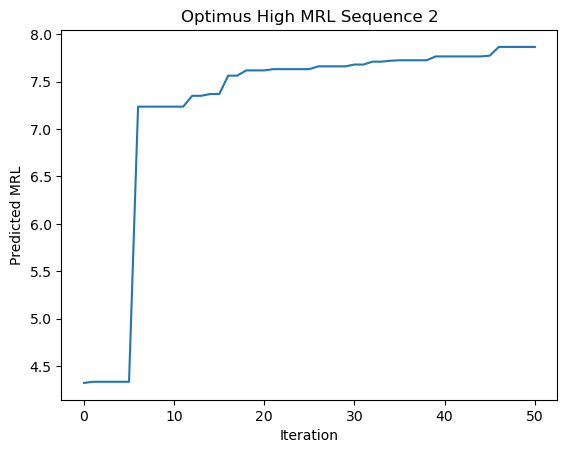

In [12]:
################### Don't need to edit these, just run this cell ####################################
#3.1 
for i in range(0, 3):
    #attempt higher mutation 
    x = get50RandomNTs()
    end_seq, values = mutagenesis_higher_mrl_optimus(x, model, scaler, 50)
    print ("Start sequence: ")
    print (x)
    print (values[0])
    print ('End sequence: ')
    print (end_seq)
    print  (values[-1])
    plotPredictionChanges(values, "Optimus High MRL Sequence " + str(i))
    